# Teaching task: Compare human behavior vs. model predictions
Natalia Vélez, October 2021

In [115]:
%matplotlib inline

import os, json, re, sys, ast
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.transforms import Bbox
from matplotlib.patches import Rectangle
from matplotlib import colors
from matplotlib.backends import backend_pdf
from tqdm.notebook import tqdm
import seaborn as sns

sys.path.append('..')
from utils import int_extract, read_json

sns.set_context('talk')
sns.set_style('white')

# Make directory to store plots in 
os.makedirs('plots/examples_agg', exist_ok=True) # avg heatmaps
os.makedirs('plots/examples_ind', exist_ok=True) # ind subjects
os.makedirs('plots/sampling_predictions', exist_ok=True) # what the model expects teachers will choose vs. what they actually chose
os.makedirs('plots/regressors', exist_ok=True) # sample regressors

Load problems:

In [2]:
problems = read_json('inputs/problems.json')
print(problems[0])

{'A': [[0, 0, 1, 1, 0, 0], [0, 1, 1, 1, 1, 0], [1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1], [0, 1, 1, 1, 1, 0], [0, 0, 1, 1, 0, 0]], 'B': [[1, 1, 1, 0, 0, 0], [1, 1, 1, 0, 0, 0], [1, 1, 1, 1, 0, 0], [0, 0, 1, 1, 0, 0], [0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0]], 'C': [[0, 0, 0, 1, 1, 1], [0, 0, 0, 1, 1, 1], [0, 0, 1, 1, 1, 1], [0, 0, 1, 1, 0, 0], [0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0]], 'D': [[0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0], [0, 0, 1, 1, 0, 0], [1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1]]}


Load behavioral data:

In [3]:
teaching_df = pd.read_csv('outputs/teaching_behavior.csv')
teaching_df.head()

,subject,run,block_idx,ex_idx,onset,problem,order,example,rating
0,1,1,0,0,30.00,22,"['C', 'B', 'D', 'A']","[1, 2]",1.0
1,1,1,0,1,45.35,22,"['C', 'B', 'D', 'A']","[4, 3]",2.0
2,1,1,0,2,59.35,22,"['C', 'B', 'D', 'A']",NaN,2.0
3,1,1,1,0,104.05,18,"['D', 'B', 'C', 'A']","[0, 3]",0.0
4,1,1,1,1,118.45,18,"['D', 'B', 'C', 'A']","[5, 2]",NaN


Load model predictions:

In [22]:
# Strong sampling
strong_model = read_json('outputs/model_predictions_strong.json')
strong_df = pd.DataFrame(strong_model)

# Sequential pedagogical sampling
pedagogical_model = read_json('outputs/model_predictions_pedagogical_n10.json') # CHANGE after debug
pedagogical_df = pd.DataFrame(pedagogical_model)

# Spatially biased model
spatial_bias_model = read_json('outputs/model_predictions_spatialbias.json')
spatial_df = pd.DataFrame(spatial_bias_model)

# Pedagogical sampling + spatial bias
spatial_pedagogical_model = read_json('outputs/model_predictions_spatialpedagogical_n10.json')
spatial_pedagogical_df = pd.DataFrame(spatial_pedagogical_model)

# Put it together
model_df = pd.concat([strong_df, pedagogical_df, spatial_df, spatial_pedagogical_df])
model_df['loglik'] = np.log(model_df.lik)
print(model_df.shape)
model_df.head()

(12852, 15)


,subject,run,block_idx,ex_idx,problem,example,model,lik,pD,pTrue,pH,entropy,delta,KL,loglik
0,1,1,0,0,22,8,strong,0.062500,"[[1, 0.0625], [2, 0.0], [3, 0.0], [4, 0.0625],...",0.305389,"[[A, 0.30538922155688625], [B, 0.2874251497005...",1.086453,0.055389,0.299841,-2.772589
1,1,1,0,1,22,27,strong,0.066667,"[[1, 0.06666666666666667], [2, 0.0], [3, 0.0],...",0.423077,"[[A, 0.423076923076923], [B, 0.0], [C, 0.0], [...",0.681266,0.117688,0.338932,-2.708050
2,1,1,1,0,18,3,strong,0.083333,"[[0, 0.08333333333333333], [3, 0.0833333333333...",0.586207,"[[A, 0.5862068965517241], [B, 0.41379310344827...",0.678209,0.336207,0.708085,-2.484907
3,1,1,1,1,18,32,strong,0.090909,"[[0, 0.09090909090909091], [6, 0.0], [7, 0.090...",0.592593,"[[A, 0.5925925925925926], [B, 0.40740740740740...",0.675901,0.006386,0.000084,-2.397895
4,1,1,1,2,18,7,strong,0.100000,"[[0, 0.1], [6, 0.0], [7, 0.1], [10, 0.1], [13,...",0.600000,"[[A, 0.6], [B, 0.39999999999999997], [C, 0.0],...",0.673012,0.007407,0.000114,-2.302585


## Model QA

QA #1: Any impossible examples?

In [17]:
model_df[model_df.lik == 0]

,subject,run,block_idx,ex_idx,problem,example,model,lik,pD,pTrue,pH,entropy,delta,KL,loglik


QA #2: Any impossible belief updates?

In [18]:
model_df[~np.isfinite(model_df.KL)]

,subject,run,block_idx,ex_idx,problem,example,model,lik,pD,pTrue,pH,entropy,delta,KL,loglik


## Model comparison

Compare model log likelihoods

[Text(0.5, 0, ''), Text(0, 0.5, 'Log likelihood')]

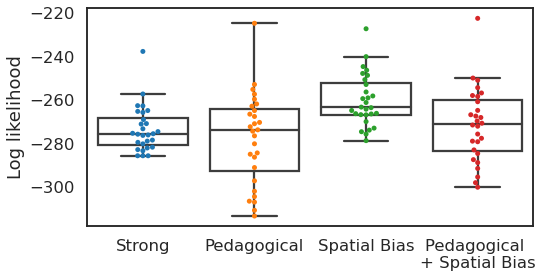

In [23]:

model_lik = model_df.groupby(['subject', 'model'])['loglik'].agg('sum').reset_index()

# Make pretty labels for plotting
model_lik['model_label'] = model_lik.model.str.title()
model_lik['model_label'] = (model_lik.model_label
                                     .str.replace('_', ' ')
                                     .str.replace('Plus', '\n+'))
model_lik['model_label'] = (model_lik.model_label
                                     .astype('category')
                                     .cat.reorder_categories(['Strong',
                                                              'Pedagogical',
                                                              'Spatial Bias',
                                                              'Pedagogical \n+ Spatial Bias']))

fig, ax = plt.subplots(figsize=(8,4))
sns.swarmplot(data=model_lik, x='model_label',y='loglik', ax=ax)
sns.boxplot(data=model_lik, x='model_label',y='loglik', 
            boxprops={'facecolor':'None'}, showfliers=False, ax=ax)
ax.set(xlabel='', ylabel='Log likelihood')

Find the model that best fits each participant

In [24]:
model_names = model_lik.model.unique()
best_model = model_lik.pivot_table(index='subject',columns='model',values='loglik').reset_index()
best_model['best'] = best_model[model_names].idxmax(axis=1)
best_model

model,subject,pedagogical,pedagogical_plus_spatial_bias,spatial_bias,strong,best
0,1,-262.823434,-258.321672,-240.024973,-257.201687,spatial_bias
1,2,-291.036016,-279.162791,-266.394641,-271.035399,spatial_bias
2,4,-261.786811,-257.904987,-248.630619,-268.966008,spatial_bias
3,5,-273.689690,-271.479318,-263.499814,-273.210967,spatial_bias
4,6,-280.117066,-275.629967,-263.241305,-275.484565,spatial_bias
5,7,-306.931476,-295.383646,-266.257377,-281.667921,spatial_bias
6,8,-286.263269,-284.568059,-269.894306,-282.785951,spatial_bias
7,9,-313.331101,-300.087591,-272.902726,-279.445378,spatial_bias
8,10,-259.615398,-256.739605,-246.278049,-265.667129,spatial_bias
9,11,-224.684379,-222.412967,-227.202087,-237.624392,pedagogical_plus_spatial_bias


In [25]:
best_model.groupby('best')['subject'].agg('count')

best
pedagogical_plus_spatial_bias     3
spatial_bias                     25
Name: subject, dtype: int64

# Plot average model predictions

Helper function: Get human example frequencies

In [47]:
def example_frequencies(prob_idx):
    # Tally number of examples
    examples = teaching_df[teaching_df['problem'] == prob_idx].copy()
    examples = examples[examples['example'].notna()]
    example_count = np.zeros((6,6))

    for _, row in examples.iterrows():
        ex = re.findall('[0-9]', row['example'])
        ex = [int(coord) for coord in ex]

        example_count[ex[0], ex[1]] += 1

    # Convert counts -> frequencies
    example_freq = example_count/np.sum(example_count) 
    return example_freq

<AxesSubplot:>

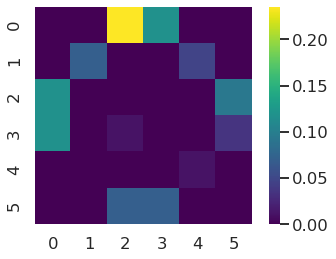

In [51]:
sns.heatmap(example_frequencies(0), cmap='viridis', square=True) # let's test it out!

Helper function: Convert sampling distribution to 6 x 6 "heatmap"

In [52]:
def sampling_matrix(row):    
    # matrix of full coordinates
    all_coords = pd.DataFrame([(i,j) for i in range(6) for j in range(6)],
                             columns=['row', 'col'])

    # get full sampling distribution
    pD = pd.DataFrame(row['pD'], columns=['idx', 'pD'])
    pD['coords'] = pD.idx.apply(lambda i: np.unravel_index(i, (6,6)))

    # "unravel" flat indices into 2d coordinates?
    coords_2d = pD.coords.apply(pd.Series)
    coords_2d.columns = ['row', 'col']

    # put it together
    pD = pd.concat([pD, coords_2d], axis=1)
    pD = pD.drop(columns=['idx', 'coords'])
    pD = all_coords.merge(pD,how='left')

    # convert df of coordinates into 2d matrix
    pD = pD.pivot('row', 'col', 'pD').values
    pD = np.nan_to_num(pD)
    
    return pD

<AxesSubplot:>

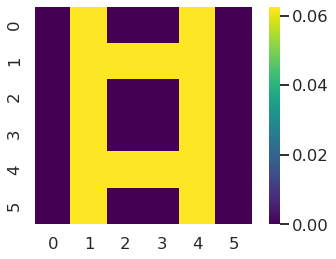

In [107]:
sns.heatmap(sampling_matrix(model_df.iloc[0]), cmap='viridis', square=True) # let's test it out!

Helper function: Get marginal sampling distribution for a given problem + model

In [108]:
def marginalize_pD(prob_idx, model):
    # get all model predictions for that problem
    df = model_df[(model_df.problem == prob_idx) & (model_df.model == model)]

    # convert all sampling distributions (p(d|h_true)) to 6x6 heatmaps
    preds = df.apply(sampling_matrix, axis=1).values.tolist()
    preds = np.dstack(preds)
    preds = np.nan_to_num(preds) # fill in empty values

    # compute marginal dist
    marginal = np.mean(preds,axis=2)
    marginal = marginal/np.sum(marginal) 
    
    return marginal

<AxesSubplot:>

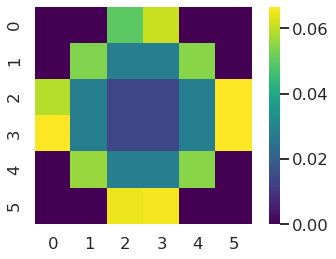

In [109]:
marginal = marginalize_pD(0, 'spatial_bias')
sns.heatmap(marginal, cmap='viridis', square=True) # let's test it out!

Putting it all together: Plot marginals vs. human behavior

In [113]:
def model_vs_avg_human(prob_idx):
    '''
    Plots average p(d|h) against average human examples
    '''
    
    models_ordered = ['strong', 'spatial_bias', 'pedagogical', 'pedagogical_plus_spatial_bias']

    fig, axes = plt.subplots(1,5, figsize=(20,4))

    # Plot model predictions
    for idx, model in enumerate(models_ordered):
        model_label = model.replace('_', ' ').replace('plus', '\n+').title()

        model_preds= marginalize_pD(prob_idx, model)
        sns.heatmap(model_preds, cmap='viridis', square=True, ax=axes[idx],cbar=False)
        axes[idx].set(title=model_label)

    # Plot human data
    human_freq = example_frequencies(prob_idx)
    sns.heatmap(human_freq, cmap='viridis', square=True, ax=axes[-1],cbar=False)
    axes[-1].set(title='Human')

    # Title figure
    fig.suptitle('Problem %i' % prob_idx)
    
    return fig

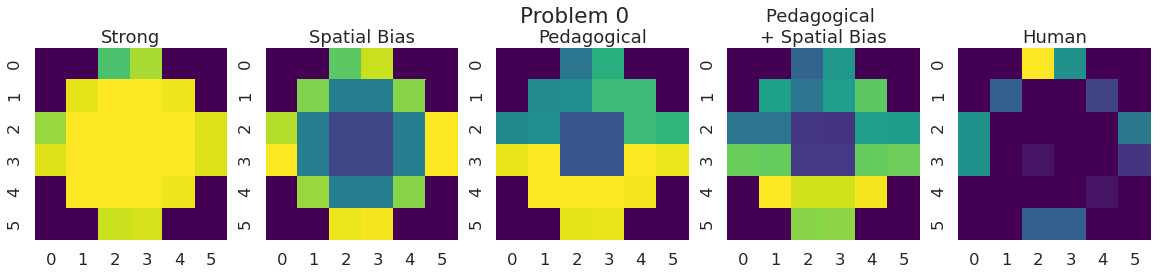

In [114]:
fig = model_vs_avg_human(0) # let's test it out!

Iterate over all problems

In [117]:
for i in tqdm(range(40)):
    pass

KeyboardInterrupt: 

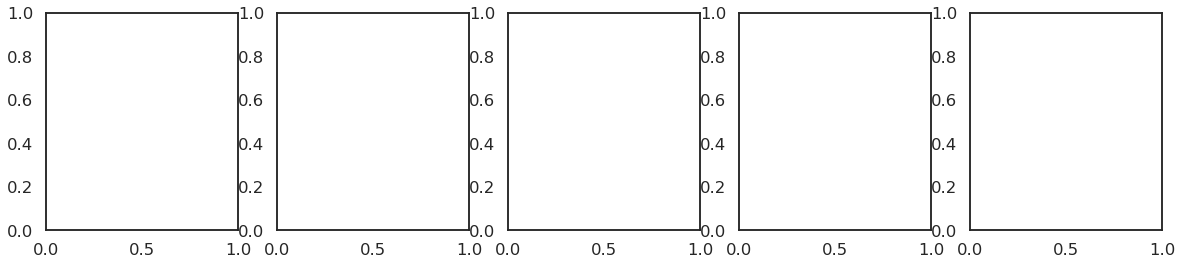

In [116]:
pdf = backend_pdf.PdfPages("plots/models_vs_avg_behavior.pdf")
for prob in tqdm(range(40)):
    fig = model_vs_avg_human(prob)
    pdf.savefig(fig)
    plt.close(fig)
pdf.close()

## Plot model predictions for single problems

Main function: Plot predictions for a single problem

In [27]:
def plot_predictions(group):

    df = group.copy().reset_index(drop=True) # copy data

    # make figure
    n_ax = group.shape[0]
    fig, axes = plt.subplots(1, n_ax, figsize=(4*n_ax,4*1.25))
    past_examples = []

    for idx, row in df.iterrows():
        if df.shape[0] > 1:
            ax = axes[idx]
        else:
            ax = axes
        
        # load true hypotheses
        true_h = np.array(problems[row.problem]['A'])
        
        # plot probability of selecting each example
        pD = sampling_matrix(row)
        sns.heatmap(pD, ax=ax, cbar=False, square=True, cmap='viridis', mask=true_h==0)
        ax.set(xticks=[],yticks=[], title='t = %i' % idx)

        # highlight the example that the teacher actually chose
        ex = np.unravel_index(row['example'], (6,6))
        ax.add_patch(Rectangle(ex[::-1], 1, 1, fill=False, edgecolor='#ff6d12', lw=3))
        
        for past_ex in past_examples:
            ax.add_patch(Rectangle(past_ex[::-1], 1, 1, facecolor='#ddd', edgecolor='#ddd', lw=2))
        past_examples.append(ex)

    fig.suptitle('sub-%02d, problem %i' % (row['subject'], row['problem']), y=0.9)
    
    return fig

Let's test it out!

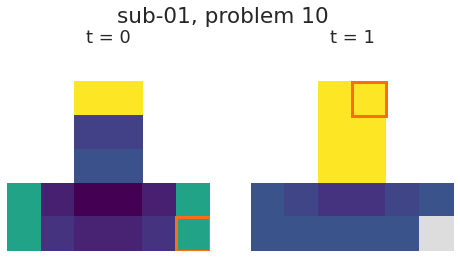

In [43]:
group = spatial_pedagogical_df[(pedagogical_df['subject'] == 1) & (pedagogical_df['problem'] == 10)] # input arg
fig = plot_predictions(group)

Plot everything:

In [25]:
for sub, sub_data in pedagogical_df.groupby('subject'):
    pdf = backend_pdf.PdfPages("plots/sampling_predictions/sub-%02d.pdf" % sub)
    for prob, prob_data in sub_data.groupby('problem'):
        fig = plot_predictions(prob_data)
        pdf.savefig(fig)
        plt.close(fig)
    pdf.close()

## Load model predictions

Helper function: Read examples

In [2]:
def parse_examples(s):
    try:
        examples = ast.literal_eval(s)
        examples = list(zip([0,1,2], examples))
    except ValueError:
        examples = re.findall('nan|\([0-9], [0-9]\)', s)
        examples = list(zip([0,1,2], examples))
        examples = [e for e in examples if e[1] != 'nan']
        examples = [(e[0], ast.literal_eval(e[1])) for e in examples]
        
    return examples

def parse_list(s):
    try:
        examples = ast.literal_eval(s)
    except ValueError:
        examples = re.findall('nan|\([0-9], [0-9]\)', s)
        examples = [e for e in examples if e != 'nan']
        examples = [ast.literal_eval(e) for e in examples]
        
    return examples

Data wrangling

In [3]:
# read raw data
model_raw = pd.read_csv('outputs/model_preds_500iter.csv', index_col=0)
model_raw = model_raw[~model_raw.subject.isin(excluded_subs)] # drop subjects
model_cols = model_raw.columns[~model_raw.columns.isin(['subject', 'run', 'problem', 'example_new'])]

# unpack list variables
model_df = model_raw.copy()
model_df['example_new'] = model_df.example_new.apply(parse_examples)
for c in model_cols:
    model_df[c] = model_df[c].apply(parse_list)


# explode df
model_df = (model_df.set_index(['subject', 'run', 'problem'])
              .apply(lambda x: x.apply(pd.Series).stack())
              .reset_index())

# unnest example columns
model_df[['ex_idx', 'example']] = model_df.example_new.apply(pd.Series)
model_df['example'] = model_df.example.apply(list)

# drop and reorder coluns
model_df = model_df.drop(columns=['run', 'level_3', 'example_new'])
#model_df = model_df[['subject', 'problem', 'ex_idx', 'example'] + model_cols] 

# rename_columns
model_df = model_df.rename(columns={'h1Gd_lit': 'literal_posterior',
                                    'dGh1_lit': 'literal_likelihood',
                                    'H_lit': 'literal_entropy',
                                    'KL_lit': 'literal_KL',
                                    'h1Gd_prag': 'pragmatic_posterior',
                                    'dGh1_prag': 'pragmatic_likelihood',
                                    'H_prag': 'pragmatic_entropy',
                                    'KL_prag': 'pragmatic_KL'})

# new: change in belief in true hypothesis
model_df['literal_delta'] = model_df.groupby(['subject', 'problem'])['literal_posterior'].diff()
model_df['literal_delta'] = model_df['literal_delta'].fillna(model_df['literal_posterior'] - 0.33)

model_df['pragmatic_delta'] = model_df.groupby(['subject', 'problem'])['pragmatic_posterior'].diff()
model_df['pragmatic_delta'] = model_df['pragmatic_delta'].fillna(model_df['pragmatic_posterior'] - 0.33)

print(model_df.shape)
model_df.head()

(3213, 14)


,subject,problem,literal_posterior,literal_entropy,literal_KL,literal_likelihood,pragmatic_posterior,pragmatic_entropy,pragmatic_KL,pragmatic_likelihood,ex_idx,example,literal_delta,pragmatic_delta
0,1,0,0.500000,0.693147,0.693147,0.041667,0.713042,0.599406,0.786889,0.079227,0,"[5, 3]",0.170000,0.383042
1,1,0,0.500000,0.693147,0.000000,0.003623,0.347059,0.645607,0.286918,0.002246,1,"[5, 2]",0.000000,-0.365983
2,1,0,1.000000,0.000000,0.693147,0.000494,1.000000,0.000000,1.058261,0.000667,2,"[0, 2]",0.500000,0.652941
3,1,1,0.333333,1.098612,0.287682,0.041667,0.001232,0.701777,0.684517,0.000137,0,"[5, 1]",0.003333,-0.328768
4,1,1,1.000000,0.000000,1.098612,0.003623,1.000000,0.000000,6.699204,0.005587,1,"[0, 1]",0.666667,0.998768


## Compare to human behavior

Load behavioral data:

In [4]:
all_behavior = pd.read_csv('outputs/teaching_behavior.csv')
all_behavior = all_behavior[~all_behavior.subject.isin(excluded_subs)]

# drop trials where the teacher did not provide an example
behavior_df = all_behavior[~all_behavior.example.isna()].reset_index(drop=True)
behavior_df['problem_idx'] = behavior_df['problem_idx'].astype(np.int)
behavior_df['ex_idx'] = behavior_df['ex_idx'].astype(np.int)
behavior_df['problem'] = behavior_df['problem'].astype(np.int)

print(behavior_df.shape)
behavior_df.tail()

(3213, 9)


/Users/nvelez/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  
/Users/nvelez/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link f

,subject,run,problem_idx,ex_idx,onset,problem,order,example,rating
3208,30,10,2,1,194.60,28,"['D', 'A', 'C', 'B']","[3, 2]",2.0
3209,30,10,2,2,209.35,28,"['D', 'A', 'C', 'B']","[1, 3]",4.0
3210,30,10,3,0,254.95,13,"['D', 'B', 'A', 'C']","[2, 2]",0.0
3211,30,10,3,1,268.95,13,"['D', 'B', 'A', 'C']","[3, 2]",2.0
3212,30,10,3,2,283.85,13,"['D', 'B', 'A', 'C']","[3, 3]",3.0


Merge with model predictions

In [5]:
# drop lists from model
model_nolist = model_df.drop(columns=['example'])

# merge behavior & model predictions
teaching_df = behavior_df.merge(model_nolist, how='left')
teaching_df['event'] = teaching_df['problem_idx']*3 + teaching_df['ex_idx']

print(teaching_df.shape)
teaching_df.head()

(3213, 20)


,subject,run,problem_idx,ex_idx,onset,problem,order,example,rating,literal_posterior,literal_entropy,literal_KL,literal_likelihood,pragmatic_posterior,pragmatic_entropy,pragmatic_KL,pragmatic_likelihood,literal_delta,pragmatic_delta,event
0,1,1,0,0,30.00,22,"['C', 'B', 'D', 'A']","[1, 2]",1.0,0.333333,1.098612,0.287682,0.062500,0.315188,1.092064,0.294231,0.063038,0.003333,-0.014812,0
1,1,1,0,1,45.35,22,"['C', 'B', 'D', 'A']","[4, 3]",2.0,0.500000,0.693147,0.405465,0.008333,0.293854,0.605567,0.404244,0.006186,0.166667,-0.021334,1
2,1,1,1,0,104.05,18,"['D', 'B', 'C', 'A']","[0, 3]",0.0,0.500000,0.693147,0.693147,0.083333,0.589748,0.676950,0.709344,0.138764,0.170000,0.259748,3
3,1,1,1,1,118.45,18,"['D', 'B', 'C', 'A']","[5, 2]",NaN,0.500000,0.693147,0.000000,0.015152,0.741225,0.571771,0.050204,0.021801,0.000000,0.151477,4
4,1,1,1,2,132.55,18,"['D', 'B', 'C', 'A']","[1, 1]",3.0,0.500000,0.693147,0.000000,0.004545,0.940911,0.224452,0.137180,0.005535,0.000000,0.199686,5


Put together regressors

In [6]:
regressor_df = pd.melt(teaching_df, id_vars=['subject', 'run', 'event'],
                       value_vars = ['literal_posterior', 'literal_entropy', 
                                     'literal_KL', 'literal_delta',
                                     'pragmatic_posterior', 'pragmatic_entropy', 
                                     'pragmatic_KL', 'pragmatic_delta'])
regressor_df['model'] = regressor_df.variable.str.extract('(literal|pragmatic)')
regressor_df['regressor'] = regressor_df.variable.str.extract('(?<=_)([A-Za-z]+$)')
regressor_df = regressor_df.drop(columns=['variable'])

regressor_df.head()

,subject,run,event,value,model,regressor
0,1,1,0,0.333333,literal,posterior
1,1,1,1,0.500000,literal,posterior
2,1,1,3,0.500000,literal,posterior
3,1,1,4,0.500000,literal,posterior
4,1,1,5,0.500000,literal,posterior


Plot distributions of regressors

In [16]:
regressor_df

,subject,run,event,value,model,regressor
0,1,1,0,0.333333,literal,posterior
1,1,1,1,0.500000,literal,posterior
2,1,1,3,0.500000,literal,posterior
3,1,1,4,0.500000,literal,posterior
4,1,1,5,0.500000,literal,posterior
...,...,...,...,...,...,...
25699,30,10,7,0.673390,pragmatic,delta
25700,30,10,8,0.000000,pragmatic,delta
25701,30,10,9,0.668500,pragmatic,delta
25702,30,10,10,0.001500,pragmatic,delta


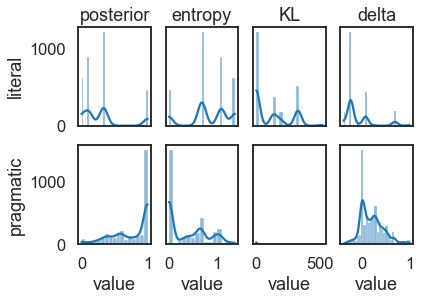

In [25]:
regressors = list(regressor_df.regressor.unique())
models = list(regressor_df.model.unique())
fig, axes = plt.subplots(2, n_regressors)

for name, group in regressor_df.groupby(['model', 'regressor']):
    model,regressor = name
    m_idx = models.index(model)
    r_idx = regressors.index(regressor)
    
    sns.histplot(group.value, ax=axes[m_idx][r_idx], kde=True)
    if m_idx == 0:
        axes[m_idx][r_idx].set(title=regressors[r_idx], xticklabels=[], xlabel='')
        
    if r_idx == 0:
        axes[m_idx][r_idx].set(ylabel = models[m_idx])
    else:
        axes[m_idx][r_idx].set(ylabel='', yticklabels=[])

Plot correlations between regressors

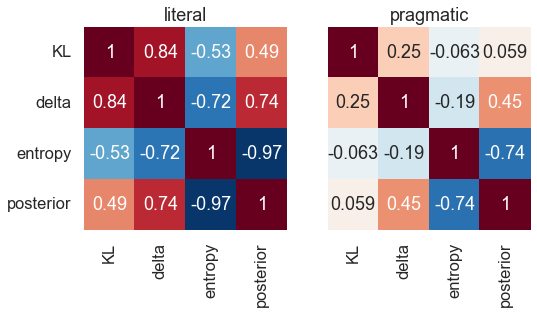

In [26]:
# make wide dataframe
index_vars = ['subject', 'run', 'event', 'model']
corr_df = regressor_df.pivot(index=index_vars, columns=['regressor'])['value'].reset_index()

# find correlations between model-predicted vars
model_vars = np.setdiff1d(corr_df.columns, index_vars)
corr_df = corr_df[['model'] + list(model_vars)]
corr_df = corr_df.groupby('model').corr()

fig, axes = plt.subplots(1,2, figsize=(8,8))
for model, ax in zip(['literal', 'pragmatic'], axes):
    sns.heatmap(corr_df.loc[model], ax=ax, annot=True, square=True,
                cbar=False, cmap='RdBu_r', center=0)
    ax.set(xlabel='', ylabel='', title=model)
    
    if model=='pragmatic':
        ax.set(yticklabels='')

Plot example regressors

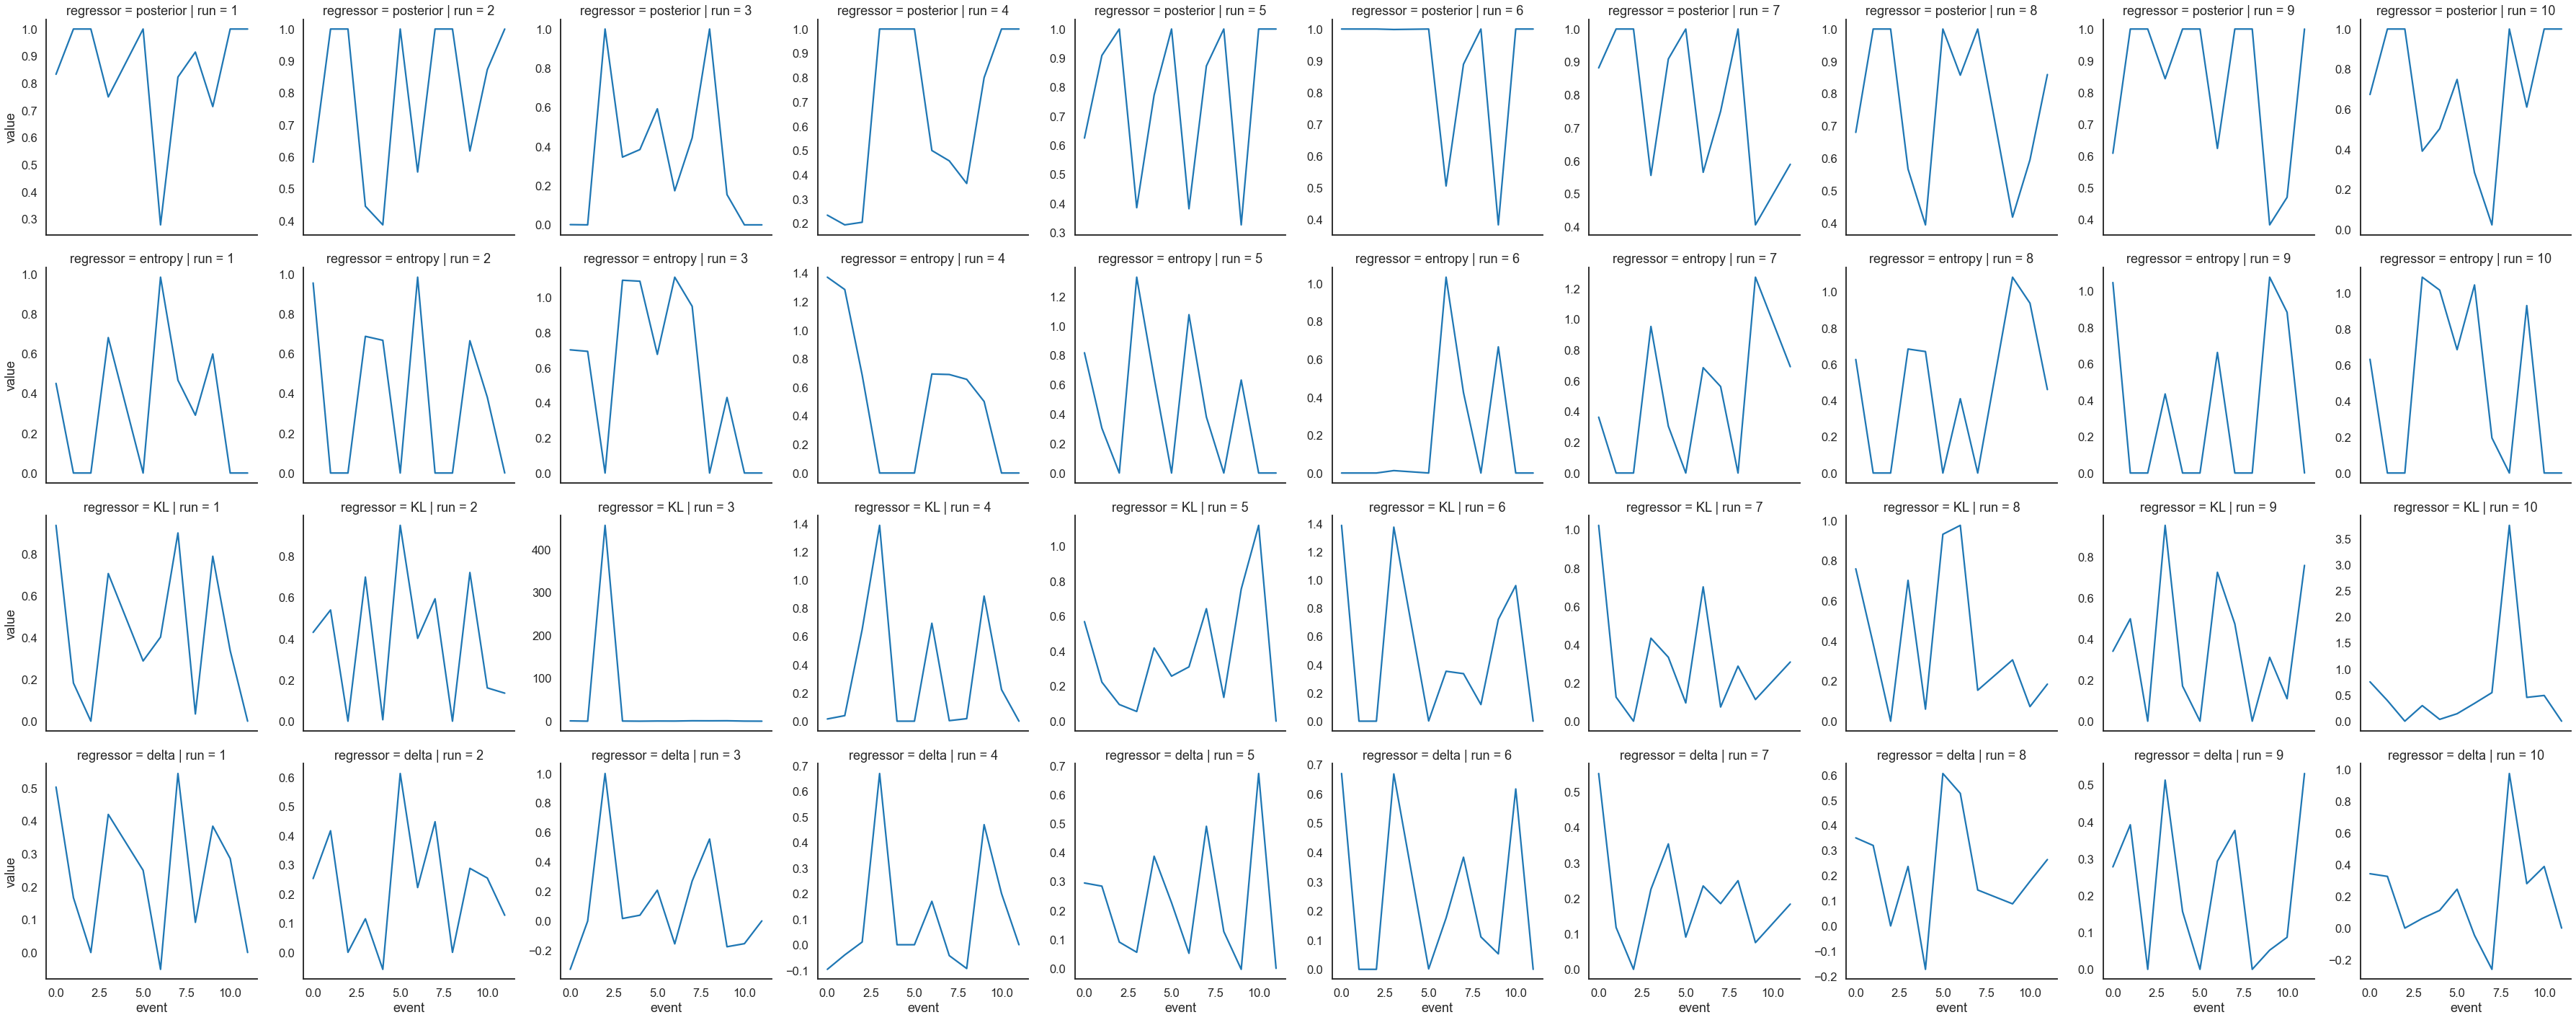

In [37]:
sub = 18
sub_df = regressor_df[(regressor_df.subject == sub) & (regressor_df.model == 'pragmatic')]
sns.relplot(
    data=sub_df, x="event", y="value",
    col="run", row="regressor",
    kind="line", facet_kws={'sharey': False, 'sharex': True}
)

In [ ]:
sub = 18
sub_df = regressor_df[(regressor_df.subject == sub) & (regressor_df.model == 'literal')]
sns.relplot(
    data=sub_df, x="event", y="value",
    col="run", row="regressor",
    kind="line", facet_kws={'sharey': False, 'sharex': True}
)